In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob, os, re, random
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from itertools import groupby
from operator import itemgetter
from datetime import datetime as dt

from fuzzywuzzy import  fuzz, process

from sklearn.preprocessing import Imputer, LabelEncoder

c:\users\rupadhyay\python 3.6\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
imputers = {}
labelEncoders = {}

In [3]:
filenames = glob.glob('./Robo/Data/trainingSet/*.csv')
data = {'trainingSet':{}, 'testSet':{}}
for filename in filenames:
    k = os.path.basename(filename)[:-4].replace('training_', '')
    data['trainingSet'][k] = pd.read_csv(filename)
    data['testSet'][k] = pd.read_csv(filename.replace('training','test'))
    


In [4]:
df0 = data['trainingSet']['SyncPatient'].copy()
df1 = data['trainingSet']['SyncDiagnosis'].copy()
df2 = data['trainingSet']['SyncTranscriptDiagnosis'].copy()
df3 = data['trainingSet']['SyncTranscript'].copy()

PATIENT DATA

In [5]:
#Calculate Patient Age
df0['Age'] = 2019 - df0['YearOfBirth']
patient_agg = df0[['Age','Gender','State','DMIndicator']]
patient_agg.index = df0.PatientGuid


In [22]:
#Using Label encoders to convert Categorical variables Age and State to numbers
lePatient = LabelEncoder()
patient_agg['State'] = lePatient.fit_transform(patient_agg['State'])
patient_agg['Gender'] = lePatient.fit_transform(patient_agg['Gender'])
labelEncoders['lePatient'] = lePatient
patient_agg.to_csv('./Robo/Data/patient.csv')


c:\users\rupadhyay\python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\rupadhyay\python 3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
patient_agg.isnull().sum()

Age            0
Gender         0
State          0
DMIndicator    0
dtype: int64

### TRANSCRIPT

#### Transcript - Outliers

In [14]:
def check_outliers(df, col,scaley=False):
    plt.figure(figsize=(4,3))
    df[col].hist()
    if scaley:
        plt.yscale('log')
    plt.title(col)
    plt.show()
    f1 = calculate_fences(df[col],1)
    f2 = calculate_fences(df[col],2)
    print(' \tstd:',f2[0],'mean:',f2[1],'range:',(f2[2],f2[3]))

In [12]:
def calculate_fences(x,strategy):
    
    if strategy == 2:
        std = round(x.dropna().std(),2)
        mean = round(x.dropna().mean(),2)
        lbound = round(mean-3*std,2)
        ubound = round(mean+3*std,2)
        return std,mean,lbound,ubound
    

In [8]:
#Features with more than 50% missing values to be dropped: Heartrate
#df3.count - 131000
df3.isnull().sum()
df3.drop(['HeartRate',],axis=1,inplace=True)

In [9]:
df3.columns.values

array(['TranscriptGuid', 'PatientGuid', 'VisitYear', 'Height', 'Weight',
       'BMI', 'SystolicBP', 'DiastolicBP', 'RespiratoryRate',
       'Temperature', 'PhysicianSpecialty', 'UserGuid'], dtype=object)

In [41]:
physician_specialty = df3[['PatientGuid','PhysicianSpecialty']].sort_values('PatientGuid').copy()
physician_specialty.fillna('x Unknown or N/A', inplace=True)
#physician_specialty.PhysicianSpecialty.unique()
physician_specialty.replace(to_replace=['Psychiatry - Child & Adolescent','Addiction Medicine (Psychiatry)',
                        'Developmental \xe2\x80\x93 Behavioral Pediatrics','Physical Medicine & Rehabilitation',
                        'Physical Therapy','x Academic (I am a student)','x Unknown or N/A'],
            value=['Psychiatry','Addiction Psychiatry','Developmental Behavioral Pediatrics',
                   'Physical Medecine', 'Physical Medecine', 'Academic', 'Unknown'],
            inplace=True)
physician_specialty.index = physician_specialty.PatientGuid
physician_specialty.drop('PatientGuid',inplace=True,axis=1)
#physician_specialty.head

#convert categorical values of specialty to numeric using get_dummies

physician_specialty = pd.get_dummies(pd.DataFrame(physician_specialty),prefix='PhySp')
#physician_specialty.head

physician_specialty.columns = map(lambda x:x.replace(' & ',' ',).replace(' ','_').replace(';','_'),physician_specialty.columns)
#physician_specialty.head

#grouping at patient level, summing all physician visits
physician_specialty = physician_specialty.reset_index().groupby('PatientGuid').sum()
#physician_specialty.head


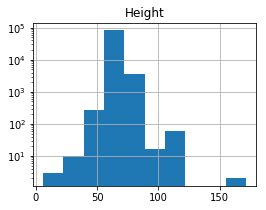

 	std: 3.71 mean: 65.92 range: (54.79, 77.05)


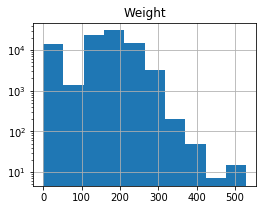

 	std: 78.76 mean: 152.72 range: (-83.56, 389.0)


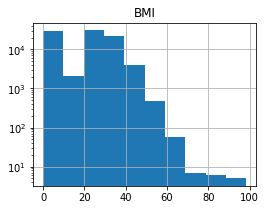

 	std: 14.83 mean: 19.77 range: (-24.72, 64.26)


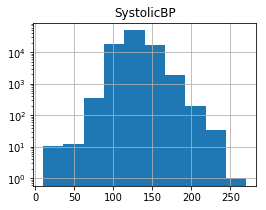

 	std: 17.27 mean: 126.73 range: (74.92, 178.54)


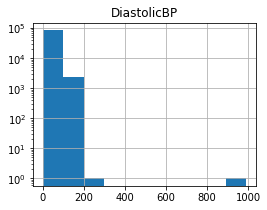

 	std: 11.32 mean: 76.6 range: (42.64, 110.56)


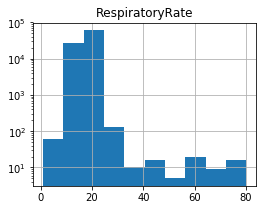

 	std: 2.34 mean: 16.92 range: (9.9, 23.94)


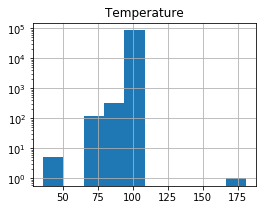

 	std: 1.21 mean: 97.76 range: (94.13, 101.39)


In [51]:
check_outliers(df3,'Height',True) #std: 5.16 mean: 65.8
check_outliers(df3,'Weight',True) #std: 97.15 mean: 102.96
check_outliers(df3,'BMI',True) #std: 1581.65 mean: 21.18
check_outliers(df3,'SystolicBP',True) #17.53 mean: 126.73
check_outliers(df3,'DiastolicBP',True) #std: 11.49 mean: 76.6
check_outliers(df3,'RespiratoryRate',True) #std: 3.09 mean: 16.92
check_outliers(df3,'Temperature',True) #std: 1.63 mean: 97.77 



In [ ]:
df3.drop(df3[df3['BMI']>100].index, inplace=True) #100 records

In [22]:
df3.drop(df3[df3['Weight']>600].index, inplace=True) 

In [42]:
df3.drop(df3[(df3['Height'].isnull()) & (df3['BMI']==0) & (df3['Weight']==0) & (df3['SystolicBP'].isnull()) & (df3['DiastolicBP'].isnull()) ].index, inplace=True) 

In [43]:
df3.describe()

,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
count,88007.000000,59895.000000,88007.000000,88007.000000,85429.000000,85429.00000,50623.000000,49204.000000
mean,1973.890600,65.923846,152.720933,19.770809,126.730911,76.60291,16.921281,97.760732
std,268.690059,4.497633,78.764507,14.825748,17.524842,11.49139,3.082798,1.616707
min,0.000000,6.000000,0.000000,0.000000,10.000000,1.00000,1.000000,36.222000
25%,2010.000000,63.000000,127.600000,0.000000,116.000000,70.00000,16.000000,97.400000
50%,2010.000000,66.000000,167.000000,24.776000,126.000000,78.00000,16.000000,97.900000
75%,2011.000000,69.000000,203.000000,30.659000,138.000000,82.00000,18.000000,98.400000
max,2012.000000,171.450000,529.109000,98.304000,270.000000,990.00000,80.000000,181.000000


Aggregate physician speciality as a sparse matrix whose columns are each speciality and each row value represents how many times a patient visited that specialist

In [20]:
df3.drop(df3[df3['BMI']>100].index, inplace=True)

Filling missing values starting with visit year by randomly choosing a year accordin to its probability

In [44]:
s1 = df3[df3.VisitYear!=0].VisitYear.value_counts(normalize=1).sort_index()
s2 = df3[df3.VisitYear == 0].index
s3 = np.random.choice(a=s1.index.tolist(),p=s1.values.tolist(),size=s2.shape[0])
#passing a dictionary in value field of replace
df3.VisitYear.replace(to_replace=0,value=dict(zip(s2,s3)),inplace=True)

Using Imputer from sklearn to impute missing values with average

In [45]:
#copy numeric features from df3
df3_numeric_vars = [u'VisitYear', u'Height', u'Weight', u'BMI', u'SystolicBP', u'DiastolicBP', 
                    u'RespiratoryRate', u'Temperature']

imputerTranscript = Imputer(strategy='mean') #replace missing values with mean of feature
imputerTranscript.fit(df3[df3_numeric_vars])
imputers['imputerTranscript'] = imputerTranscript
#imputers
df3[df3_numeric_vars] = imputerTranscript.transform(df3[df3_numeric_vars])
#df3.isnull().sum()

Aggregate Data by Min, Max, std and mean

In [46]:
tdf = df3[[u'PatientGuid', u'Height', u'Weight', u'BMI', u'SystolicBP', u'DiastolicBP', u'RespiratoryRate', u'Temperature']].copy()
#tdf.head

transcript_max = tdf.groupby('PatientGuid').max().sort_index()
transcript_min = tdf.groupby('PatientGuid').min().sort_index()
transcript_std = tdf.groupby('PatientGuid').std().sort_index()
transcript_mean = tdf.groupby('PatientGuid').mean().sort_index()



Aggregate data by recent activities: generate a table where each patient is matched with his/her 2 most recent visits. From here, we will be able to determine changes in BMI, BP and Weight which are in most cases signs of diabetes

In [47]:
tdf = df3[[u'PatientGuid', u'VisitYear', u'Height', u'Weight', u'BMI', u'SystolicBP', u'DiastolicBP', u'RespiratoryRate', u'Temperature']].copy()
transcript_last_0 = tdf.sort_values(['VisitYear','PatientGuid']).groupby('PatientGuid').nth([-1]).sort_index()
transcript_last_1 = tdf.sort_values(['VisitYear','PatientGuid']).groupby('PatientGuid').nth([-2]).sort_index()
#transcript_last_0
transcript_change = (transcript_last_0 - transcript_last_1).abs()
#transcript_change
transcript_change['VisitYear'] += 1
#transcript_change.T transforms rows to columns
transcript_change = (transcript_change.T / transcript_change.VisitYear).T
transcript_change.drop('VisitYear',axis=1,inplace=True)


In [48]:
#rename columns
transcript_max.columns = map(lambda x:x+'_Max', transcript_max.columns)
transcript_min.columns = map(lambda x:x+'_Min', transcript_min.columns)
transcript_std.columns = map(lambda x:x+'_Std', transcript_std.columns)
transcript_mean.columns = map(lambda x:x+'_Mean', transcript_mean.columns)
transcript_change.columns = map(lambda x:x+'_Change', transcript_change.columns)

#merge dataframes 
transcript_agg = pd.concat([transcript_max,transcript_min,transcript_std,transcript_mean,transcript_change], axis=1)


In [50]:
transcript_agg.to_csv('./Robo/Data/transcript.csv')
physician_specialty.to_csv('./Robo/Data/physician_specialty.csv')


## Diagnosis 
#### Diagnosis - Aggregation

Categorize 3500+ ICD9 codes among 20 categories refering to https://en.wikipedia.org/wiki/List_of_ICD-9_codes. Using get_dummies to get a binary table.

Run quick analysis with the purpose to find patients that were diagnozed with one diagnosis multiple times. Also, verify if this diagnosis is acute or chronic.

In [83]:
def categorize_icd9code(code,method = 1):
    icd9code = {    
        '001-139': 'infectious and parasitic',
        '140-239': 'neoplasms',
        '240-279': 'endocrine, nutritional and metabolic, immunity disorders',
        '280-289': 'diseases of the blood and blood-forming organs',
        '290-319': 'mental disorders',
        '320-359': 'nervous system',
        '360-389': 'sense organs',
        '390-459': 'circulatory system',
        '460-519': 'respiratory system',
        '520-579': 'digestive system',
        '580-629': 'genitourinary system',
        '630-679': 'complications of pregnancy, childbirth, and the puerperium',
        '680-709': 'skin and subcutaneous tissue',
        '710-739': 'musculoskeletal system and connective tissue',
        '740-759': 'congenital anomalies',
        '760-779': 'certain conditions originating in the perinatal period',
        '780-799': 'symptoms, signs, and ill-defined conditions',
        '800-999': 'injury and poisoning',
        'E-V': 'external causes of injury and supplemental classification'
    }
    if method == 1:
        code = code.split('.')[0]
        if ('E' in code.upper()) or ('V' in code.upper()): return 'E-V'
        elif int(code) < 139: return '001-139'
        elif int(code) < 239: return '140-239'
        elif int(code) < 279: return '240-279'
        elif int(code) < 289: return '280-289'
        elif int(code) < 319: return '290-319'
        elif int(code) < 359: return '320-359'
        elif int(code) < 389: return '360-389'
        elif int(code) < 459: return '390-459'
        elif int(code) < 519: return '460-519'
        elif int(code) < 579: return '520-579'
        elif int(code) < 629: return '580-629'
        elif int(code) < 679: return '630-679'
        elif int(code) < 709: return '680-709'
        elif int(code) < 739: return '710-739'
        elif int(code) < 759: return '740-759'
        elif int(code) < 779: return '760-779'
        elif int(code) < 799: return '780-799'
        elif int(code) < 899: return '800-899'
        else: return 'Unknown'
        
    if method == 2:
        return icd9code[categorize_icd9code(code)]

    if method == 3:
        return icd9code[code]


In [102]:
df1 = data['trainingSet']['SyncDiagnosis'].copy()
#df1.head()
#df1.shape
#df1.isnull().sum() StopYear has most Null values
#df1.describe() StartYear has 0 value for more than 50% records
df1.drop(['StartYear','StopYear'],axis=1,inplace=True)
df1['ICD9CodeCategory'] = df1.ICD9Code.apply(lambda x:categorize_icd9code(x,1))
#df1


In [119]:
diagnosis_agg = df1['ICD9CodeCategory']
diagnosis_agg.index = df1.PatientGuid
diagnosis_agg = pd.get_dummies(diagnosis_agg,prefix='Icd9',prefix_sep='_').reset_index().groupby('PatientGuid').sum()
#diagnosis_agg

s1 = diagnosis_agg.sum(axis=1) #sum of all the diagnosed categories per row
#s1
s2 = (diagnosis_agg>0).sum(axis=1) #only where there's any diagnosis
#s1.sum()
#s2.sum()

diagnosis_agg['DiagnosisCount'] = s1
diagnosis_agg['VisitCount'] = s2
diagnosis_agg['DiagnosisFreq'] = s1/s2

diagnosis_agg['AcuteCount'] = df1[['PatientGuid','Acute']].groupby('PatientGuid').sum()
diagnosis_agg['AcuteFreq'] = df1[['PatientGuid','Acute']].groupby('PatientGuid').sum()/df1[['PatientGuid','Acute']].groupby('PatientGuid').count()




In [123]:
diagnosis_agg.to_csv('./Robo/Data/diagnosis.csv')

In [124]:
diagnosis_agg

,Icd9_001-139,Icd9_140-239,Icd9_240-279,Icd9_280-289,Icd9_290-319,Icd9_320-359,Icd9_360-389,Icd9_390-459,Icd9_460-519,Icd9_520-579,...,Icd9_760-779,Icd9_780-799,Icd9_800-899,Icd9_E-V,Icd9_Unknown,DiagnosisCount,VisitCount,DiagnosisFreq,AcuteCount,AcuteFreq
PatientGuid,,,,,,,,,,,,,,,,,,,,,
00023761-9D8D-445B-874C-2424CC7CF620,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,3,3,1.000000,0,0.000000
0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,5,4,1.250000,0,0.000000
000B4862-7CE7-4EC5-8043-A97FCD74BD78,0,0,0,0,0,0,1,3,1,0,...,0,6,0,1,0,12,5,2.400000,0,0.000000
00110ABC-DAB9-49E3-A1C8-88BBF8D58109,0,0,1,0,0,0,0,2,0,0,...,0,0,2,1,0,8,6,1.333333,1,0.125000
002667F4-B9A3-4DE2-875F-8034DD637865,0,0,4,0,0,0,0,2,1,0,...,0,0,0,0,0,7,3,2.333333,0,0.000000
0029BBC8-7C22-4444-9F44-87BEF05FE033,2,0,2,0,2,2,0,0,0,1,...,0,2,0,1,0,17,10,1.700000,2,0.117647
003CEE1F-5BF5-4171-9284-F5464EC12D41,0,0,2,0,0,0,0,2,1,0,...,0,1,0,7,0,15,7,2.142857,0,0.000000
004382BD-E31F-4091-8DE5-E86A59D70C2D,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,3,3,1.000000,0,0.000000
004AACFF-5D67-49B3-81F4-883A72A2AB97,0,0,0,0,1,0,0,0,2,1,...,0,0,0,1,0,8,5,1.600000,4,0.500000
